In [1]:
from google.colab import files

# Prompt user to upload required files
uploaded = files.upload()

Saving mock_1-1-MOODSTUDY_2024-08-21_prv.csv to mock_1-1-MOODSTUDY_2024-08-21_prv.csv
Saving updated_1-1-MOODSTUDY_2024-08-29_prv.csv to updated_1-1-MOODSTUDY_2024-08-29_prv.csv
Saving updated_1-1-MOODSTUDY_2024-09-21_prv.csv to updated_1-1-MOODSTUDY_2024-09-21_prv.csv
Saving updated_968046_FrontView_Labels.xlsx to updated_968046_FrontView_Labels.xlsx
Saving updated_968048_FrontView_Labels.xlsx to updated_968048_FrontView_Labels.xlsx
Saving updated_968050_FrontView_Labels.xlsx to updated_968050_FrontView_Labels.xlsx


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta


In [3]:
# Correct session date for each participant
session_dates = {
    'participant1': '2024-08-21',
    'participant2': '2024-08-29',
    'participant3': '2024-09-21'
}


In [4]:
# Participant label and HRV mapping
participants = {
    'participant1': ('updated_968050_FrontView_Labels.xlsx', 'mock_1-1-MOODSTUDY_2024-08-21_prv.csv'),
    'participant2': ('updated_968046_FrontView_Labels.xlsx', 'updated_1-1-MOODSTUDY_2024-08-29_prv.csv'),
    'participant3': ('updated_968048_FrontView_Labels.xlsx', 'updated_1-1-MOODSTUDY_2024-09-21_prv.csv')
}


In [5]:
padding = timedelta(minutes=2)

def extract_segment(df, start, end, clip_name):
    padded_start = start - padding
    padded_end = end + padding
    segment = df[(df['timestamp_iso'] >= padded_start) & (df['timestamp_iso'] <= padded_end)].copy()
    segment['clip'] = clip_name
    return segment


In [17]:
all_segments = []

for pid, (label_file, hrv_file) in participants.items():
    print(f"\n🔍 Processing {pid}")

    try:
        labels_df = pd.read_excel(label_file)
        hrv_df = pd.read_csv(hrv_file, parse_dates=['timestamp_iso'])
        print(f"✅ Loaded: {label_file}, {hrv_file}")
    except Exception as e:
        print(f"❌ Failed to load {pid}: {e}")
        continue

    # Create datetime from session date and clip times
    labels_df['start_time'] = pd.to_datetime(session_dates[pid]) + pd.to_timedelta('00:' + labels_df['music_starttime'])
    labels_df['end_time'] = pd.to_datetime(session_dates[pid]) + pd.to_timedelta('00:' + labels_df['music_endtime'])

    # Convert to timezone-aware timestamps
    labels_df['start_time'] = labels_df['start_time'].dt.tz_localize('UTC')
    labels_df['end_time'] = labels_df['end_time'].dt.tz_localize('UTC')

    # Label clip type
    labels_df['type'] = labels_df['File_name'].apply(lambda x: 'Audio' if 'Audio' in x else 'Video')

    extracted_count = 0
    for _, row in labels_df.iterrows():
        segment = extract_segment(hrv_df, row['start_time'], row['end_time'], row['File_name'])
        if not segment.empty:
            segment['participant'] = pid
            segment['Q1'] = row.get('Q1', np.nan)
            segment['Q2'] = row.get('Q2', np.nan)
            segment['Q3'] = row.get('Q3', np.nan)
            segment['Q4'] = row.get('Q4', np.nan)
            segment['Emotion'] = row.get('Emotion', np.nan)
            segment['type'] = row['type']
            all_segments.append(segment)
            extracted_count += len(segment)

# Combine all data
combined_df = pd.concat(all_segments, ignore_index=True)

# Summary Statistics by Clip Type
audio_vs_video_summary = combined_df.groupby('type')[['prv_rmssd_ms', 'Q1', 'Q2', 'Q3', 'Q4']].agg(['mean', 'std', 'count']).round(2)

print("\n🎧 Audio vs 🎥 Video Summary (HRV & Ratings):")
print(audio_vs_video_summary)


🔍 Processing participant1
✅ Loaded: updated_968050_FrontView_Labels.xlsx, mock_1-1-MOODSTUDY_2024-08-21_prv.csv

🔍 Processing participant2
✅ Loaded: updated_968046_FrontView_Labels.xlsx, updated_1-1-MOODSTUDY_2024-08-29_prv.csv

🔍 Processing participant3
✅ Loaded: updated_968048_FrontView_Labels.xlsx, updated_1-1-MOODSTUDY_2024-09-21_prv.csv

🎧 Audio vs 🎥 Video Summary (HRV & Ratings):
      prv_rmssd_ms                Q1                Q2                Q3  \
              mean   std count  mean   std count  mean   std count  mean   
type                                                                       
Audio         1.09  0.55   148  3.41  1.64   148  3.29  1.28   148  2.96   
Video         1.13  0.47   162  3.06  1.79   162  3.72  1.07   162  3.25   

                     Q4              
        std count  mean   std count  
type                                 
Audio  1.27   148  0.50  0.50   148  
Video  1.47   162  0.67  0.47   162  


In [18]:

# Map 'Emotion' to new 'Emotion_Label'
def map_emotion_label(emotion):
    if isinstance(emotion, str):
        emotion = emotion.lower().strip()
        if emotion in ['relaxed', 'happy']:
            return 'positive'
        elif emotion in ['angry', 'sad']:
            return 'negative'
    return 'neutral'

combined_df['Emotion_Label'] = combined_df['Emotion'].apply(map_emotion_label)

# Split the dataset by modality
audio_df = combined_df[combined_df['type'] == 'audio']
video_df = combined_df[combined_df['type'] == 'video']

# Define order for consistency in plots
emotion_order = ['positive', 'neutral', 'negative']



In [19]:
!pip install pyAudioAnalysis


In [9]:
print("Participants in data:", combined_df['participant'].unique())
print("Total segments loaded:", len(combined_df))


Participants in data: ['participant1' 'participant2' 'participant3']
Total segments loaded: 310


In [21]:
summary_df = (
    combined_df
    .groupby(['clip', 'participant', 'type', 'Emotion_Label'])['prv_rmssd_ms']
    .agg(['mean', 'std', 'min', 'max'])
    .reset_index()
    .rename(columns={
        'mean': 'HRV_mean',
        'std': 'HRV_std',
        'min': 'HRV_min',
        'max': 'HRV_max'
    })
)


<ipython-input-22-afd7b30ef612>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
<ipython-input-22-afd7b30ef612>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


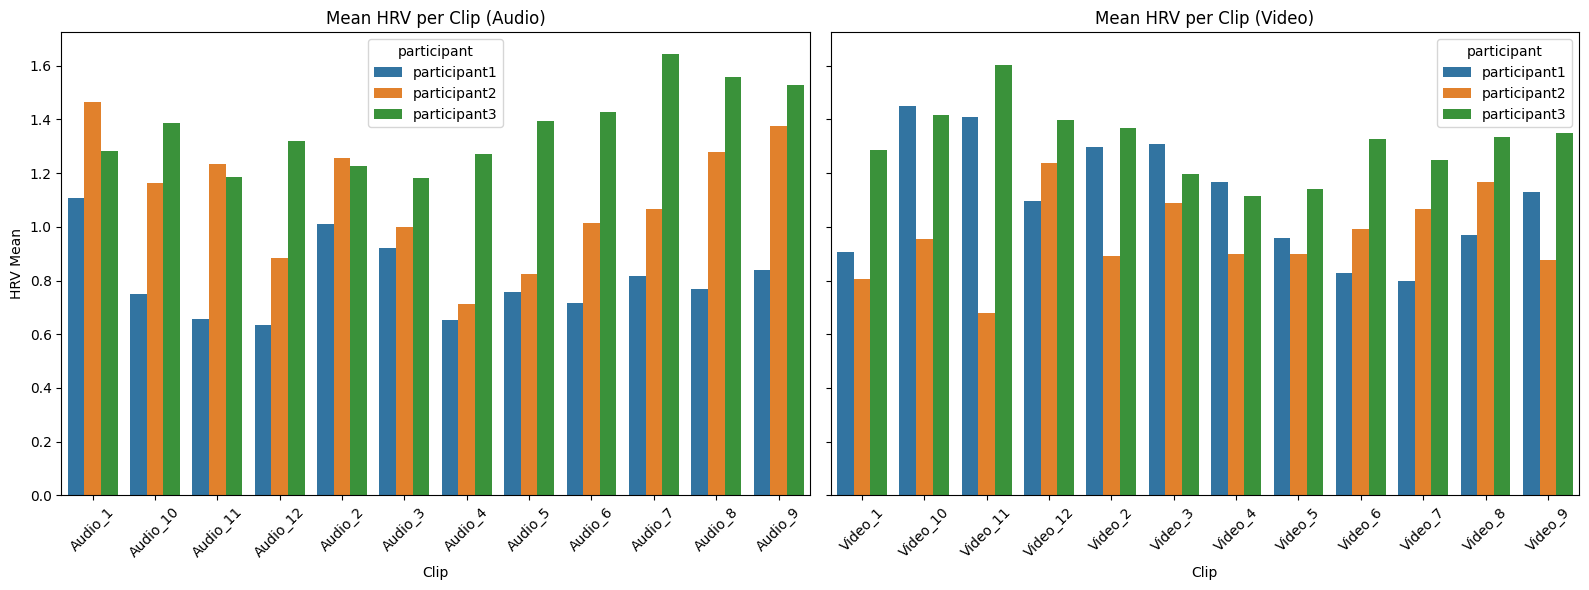

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Separate summary data by type
audio_summary = summary_df[summary_df['type'].str.lower() == 'audio']
video_summary = summary_df[summary_df['type'].str.lower() == 'video']

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot for Audio
sns.barplot(data=audio_summary, x='clip', y='HRV_mean', hue='participant', ax=axes[0])
axes[0].set_title('Mean HRV per Clip (Audio)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_xlabel('Clip')
axes[0].set_ylabel('HRV Mean')

# Plot for Video
sns.barplot(data=video_summary, x='clip', y='HRV_mean', hue='participant', ax=axes[1])
axes[1].set_title('Mean HRV per Clip (Video)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_xlabel('Clip')
axes[1].set_ylabel('')  # No need to repeat Y-axis label

plt.tight_layout()
plt.show()


<ipython-input-23-0bf588ea7e12>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=audio_subset, x='clip', y='HRV_mean', palette='Blues', ax=axes[0])
<ipython-input-23-0bf588ea7e12>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
<ipython-input-23-0bf588ea7e12>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=video_subset, x='clip', y='HRV_mean', palette='Oranges', ax=axes[1])
<ipython-input-23-0bf588ea7e12>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLoc

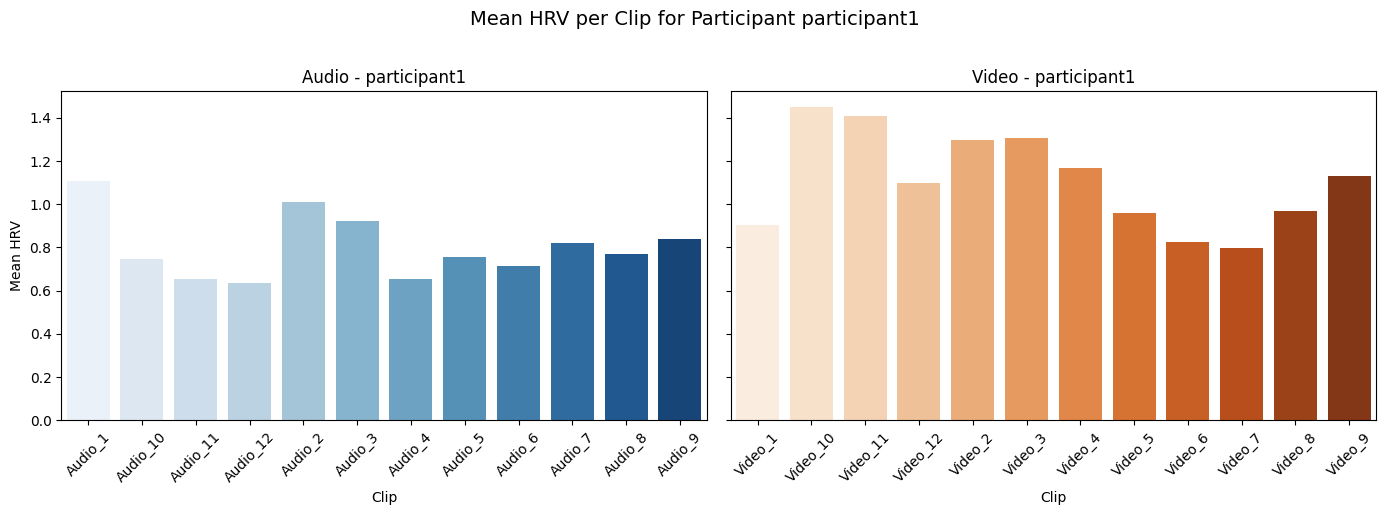

<ipython-input-23-0bf588ea7e12>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=audio_subset, x='clip', y='HRV_mean', palette='Blues', ax=axes[0])
<ipython-input-23-0bf588ea7e12>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
<ipython-input-23-0bf588ea7e12>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=video_subset, x='clip', y='HRV_mean', palette='Oranges', ax=axes[1])
<ipython-input-23-0bf588ea7e12>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLoc

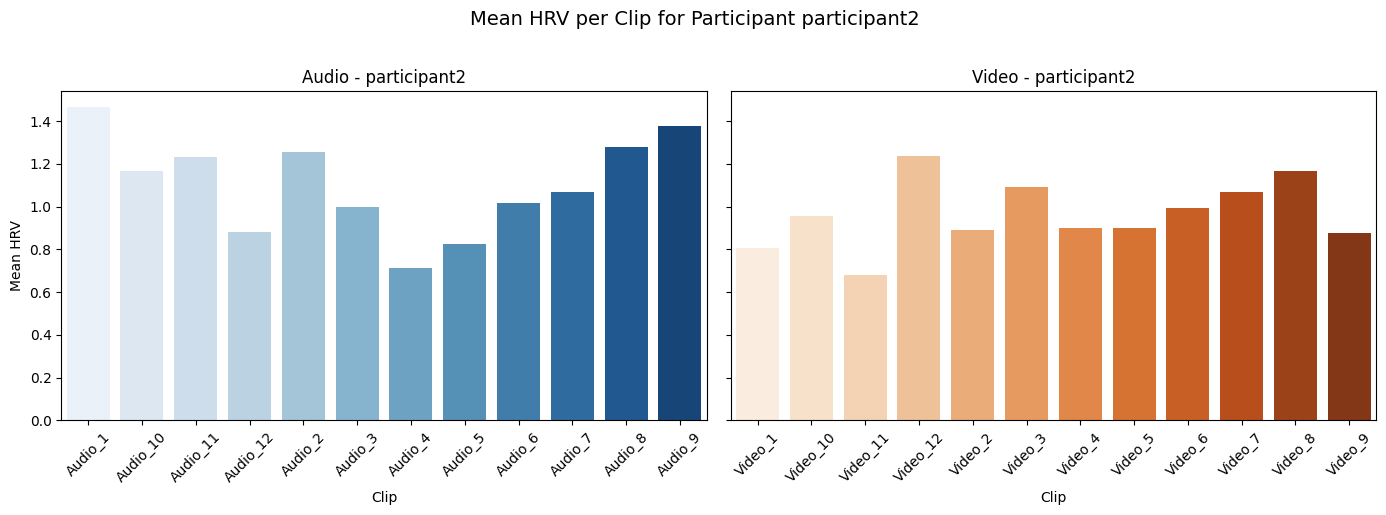

<ipython-input-23-0bf588ea7e12>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=audio_subset, x='clip', y='HRV_mean', palette='Blues', ax=axes[0])
<ipython-input-23-0bf588ea7e12>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
<ipython-input-23-0bf588ea7e12>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=video_subset, x='clip', y='HRV_mean', palette='Oranges', ax=axes[1])
<ipython-input-23-0bf588ea7e12>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLoc

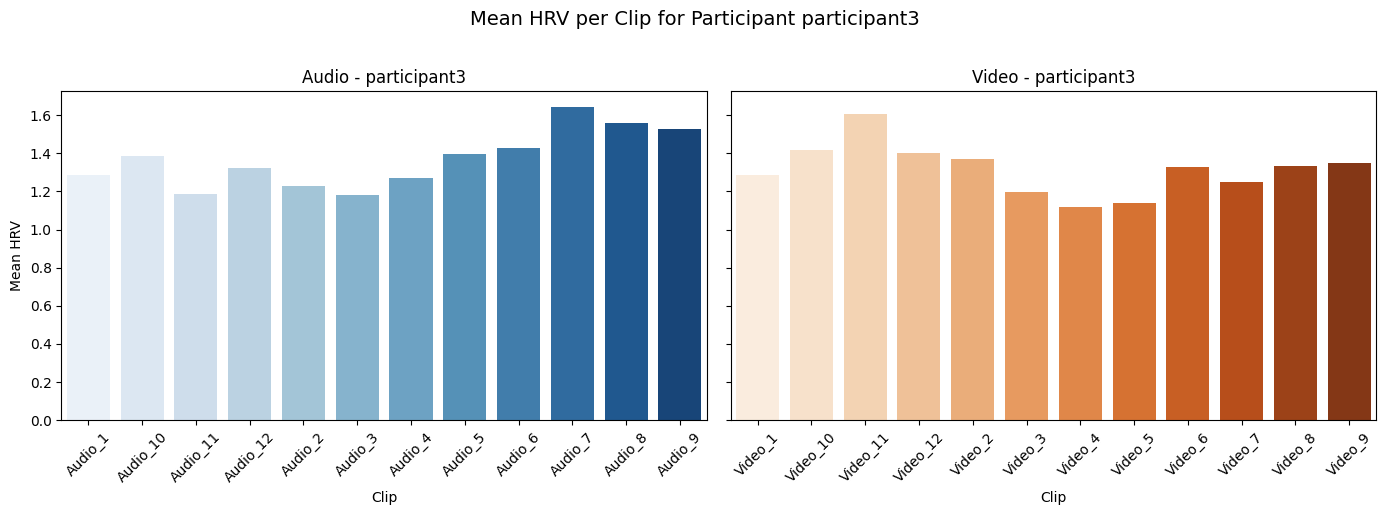

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

for pid in summary_df['participant'].unique():
    subset = summary_df[summary_df['participant'] == pid]
    audio_subset = subset[subset['type'].str.lower() == 'audio']
    video_subset = subset[subset['type'].str.lower() == 'video']

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    # Audio plot
    sns.barplot(data=audio_subset, x='clip', y='HRV_mean', palette='Blues', ax=axes[0])
    axes[0].set_title(f'Audio - {pid}')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
    axes[0].set_xlabel('Clip')
    axes[0].set_ylabel('Mean HRV')

    # Video plot
    sns.barplot(data=video_subset, x='clip', y='HRV_mean', palette='Oranges', ax=axes[1])
    axes[1].set_title(f'Video - {pid}')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
    axes[1].set_xlabel('Clip')
    axes[1].set_ylabel('')  # Shared Y-axis

    plt.suptitle(f'Mean HRV per Clip for Participant {pid}', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()


<ipython-input-24-0af1cd1592e3>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


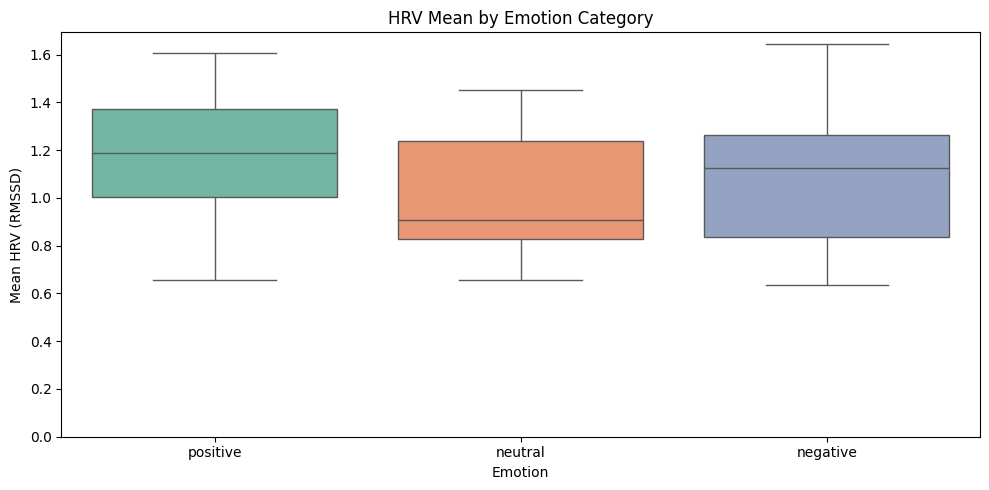

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(
    data=summary_df,
    x='Emotion_Label',
    y='HRV_mean',
    order=['positive', 'neutral', 'negative'],  # consistent order
    palette='Set2'
)
plt.ylim(bottom=0)  # 👈 ensure y-axis starts at 0
plt.title('HRV Mean by Emotion Category')
plt.xlabel('Emotion')
plt.ylabel('Mean HRV (RMSSD)')
plt.tight_layout()
plt.show()


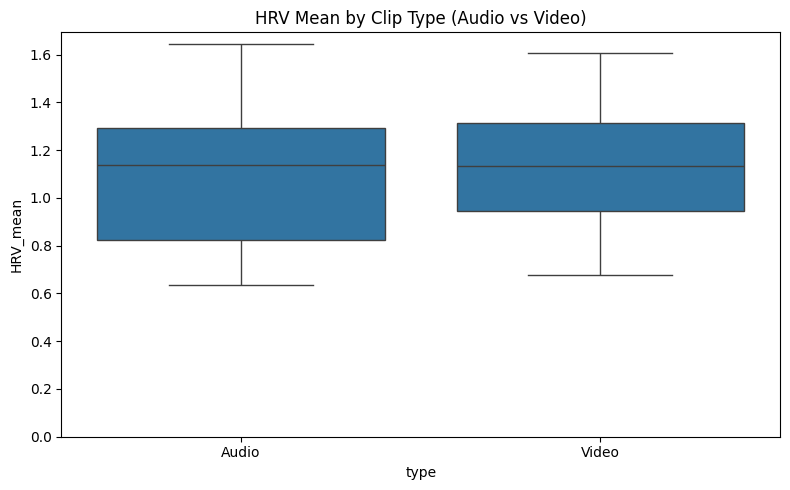

In [25]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=summary_df, x='type', y='HRV_mean')
plt.ylim(bottom=0)  # 👈 Start y-axis at 0
plt.title('HRV Mean by Clip Type (Audio vs Video)')
plt.tight_layout()
plt.show()


<ipython-input-33-825d4b207150>:19: UserWarning: Glyph 128147 (\N{BEATING HEART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128147 (\N{BEATING HEART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


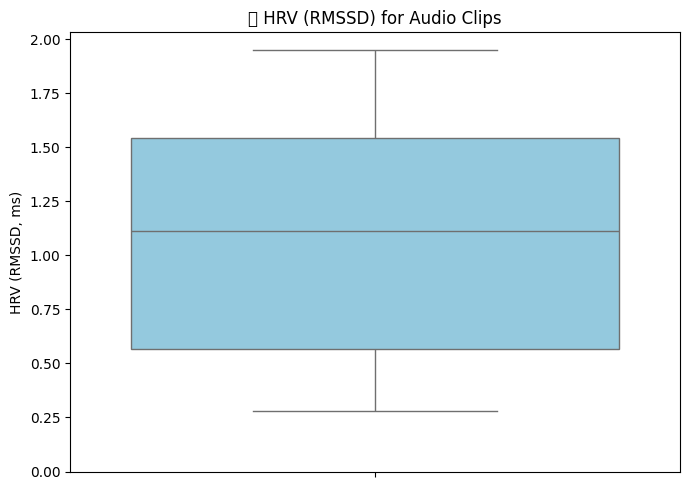

<ipython-input-33-825d4b207150>:19: UserWarning: Glyph 128147 (\N{BEATING HEART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128147 (\N{BEATING HEART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


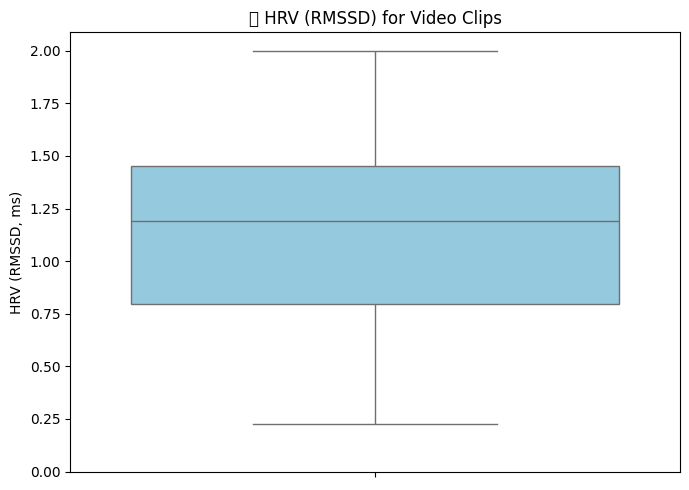

<ipython-input-33-825d4b207150>:35: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


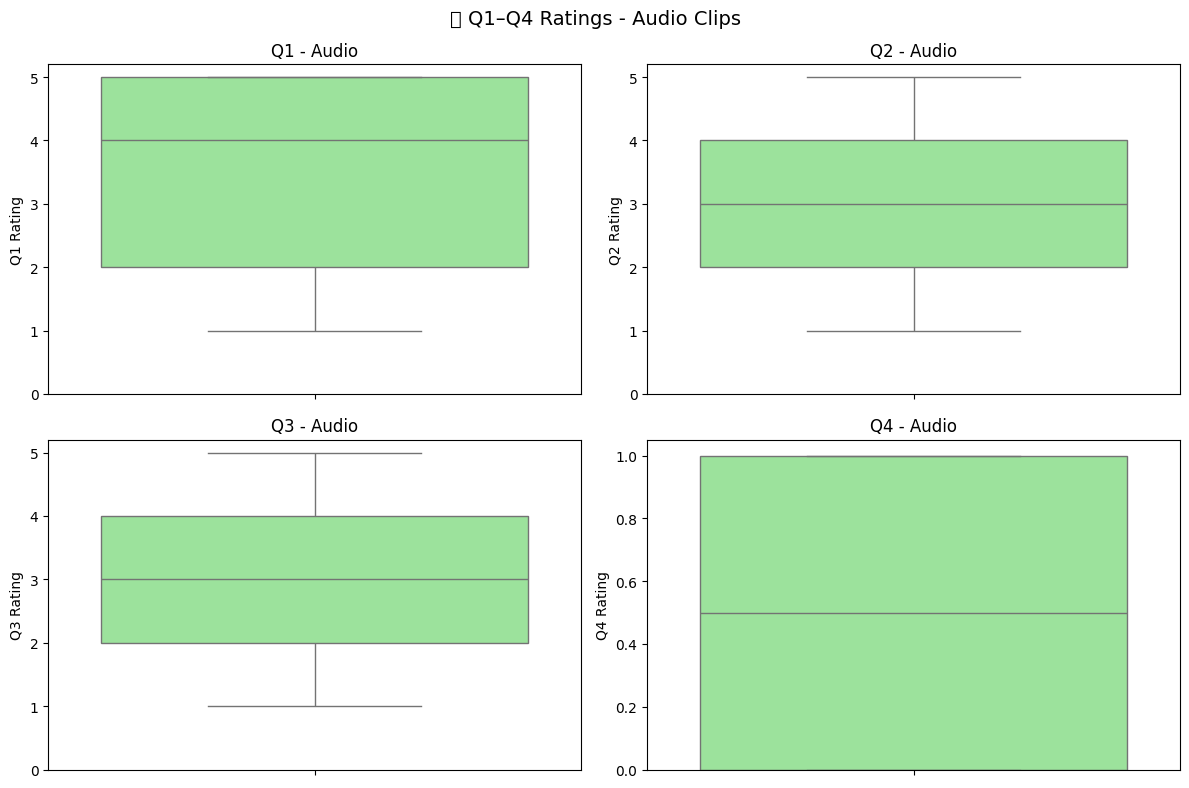

<ipython-input-33-825d4b207150>:50: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


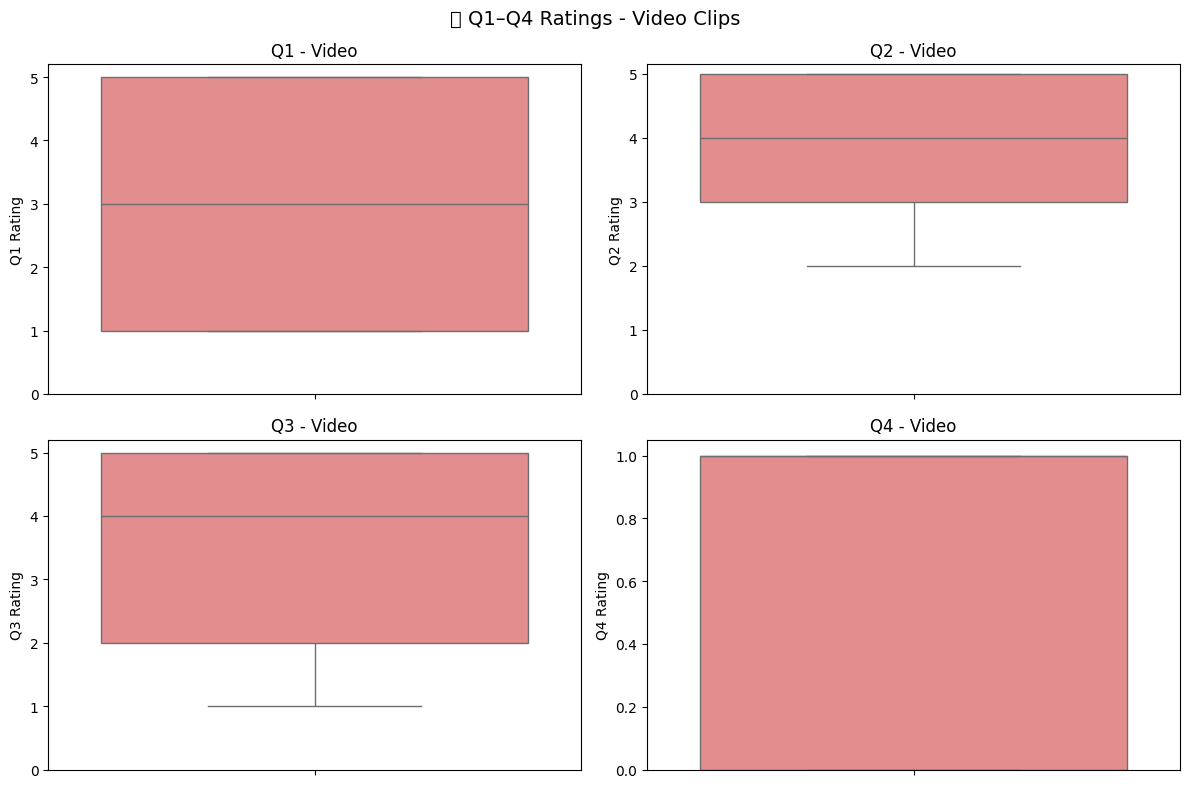

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Normalize 'type' values to lowercase for consistency
combined_df['type'] = combined_df['type'].str.lower().str.strip()

# Separate audio and video data
audio_df = combined_df[combined_df['type'] == 'audio']
video_df = combined_df[combined_df['type'] == 'video']

# 🎯 HRV Boxplots: Audio and Video
for df, label in zip([audio_df, video_df], ['Audio', 'Video']):
    plt.figure(figsize=(7, 5))
    sns.boxplot(data=df, y='prv_rmssd_ms', color='skyblue')
    #sns.stripplot(data=df, y='prv_rmssd_ms', color='black', alpha=0.4, jitter=0.2)
    plt.ylim(bottom=0)
    plt.title(f'💓 HRV (RMSSD) for {label} Clips')
    plt.ylabel('HRV (RMSSD, ms)')
    plt.tight_layout()
    plt.show()

# 📋 Q1–Q4 Boxplots in 2×2 layout for Audio
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
questions = ['Q1', 'Q2', 'Q3', 'Q4']

for i, q in enumerate(questions):
    ax = axes[i // 2, i % 2]
    sns.boxplot(data=audio_df, y=q, ax=ax, color='lightgreen')
    #sns.stripplot(data=audio_df, y=q, ax=ax, color='black', alpha=0.4, jitter=0.2)
    ax.set_title(f'{q} - Audio')
    ax.set_ylim(bottom=0)
    ax.set_ylabel(f'{q} Rating')

plt.suptitle('📊 Q1–Q4 Ratings - Audio Clips', fontsize=14)
plt.tight_layout()
plt.show()

# 📋 Q1–Q4 Boxplots in 2×2 layout for Video
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, q in enumerate(questions):
    ax = axes[i // 2, i % 2]
    sns.boxplot(data=video_df, y=q, ax=ax, color='lightcoral')
    #sns.stripplot(data=video_df, y=q, ax=ax, color='black', alpha=0.4, jitter=0.2)
    ax.set_title(f'{q} - Video')
    ax.set_ylim(bottom=0)
    ax.set_ylabel(f'{q} Rating')

plt.suptitle('📊 Q1–Q4 Ratings - Video Clips', fontsize=14)
plt.tight_layout()
plt.show()


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Drop missing emotion rows
ml_df = combined_df.dropna(subset=['Emotion_Label'])

# Encode emotion as label
ml_df['Emotion_Label_Code'] = ml_df['Emotion_Label'].astype('category').cat.codes

X = ml_df[['prv_rmssd_ms', 'Q1', 'Q2', 'Q3', 'Q4']]
y = ml_df['Emotion_Label_Code']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("🎯 Emotion Classification Report:")
print(classification_report(y_test, y_pred))




🎯 Emotion Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.77      0.69        30
           1       0.82      0.60      0.69        15
           2       0.80      0.73      0.76        33

    accuracy                           0.72        78
   macro avg       0.75      0.70      0.71        78
weighted avg       0.73      0.72      0.72        78



## Takeaway from the Random Forest Model

The Random Forest classifier was able to predict participant emotions with meaningful accuracy using only HRV (RMSSD) and self-reported questionnaire scores (Q1–Q4). This suggests that physiological data combined with subjective feedback provides enough signal to distinguish between emotional states without requiring video/audio content. Despite not having raw media or facial expression data, the model demonstrated the feasibility of lightweight emotion classification based on sensor and self-report inputs.
